# Diffusion Entropy Analysis
Garland Culbreth, Jacob Baxley, David Lambert  
_Center for Nonlinear Science, University of North Texas_


## Work here
---

### Set plot styling and appearance

Use this cell to customize plot appearance, if desired. See the seaborn `set_theme` [documentation page](https://seaborn.pydata.org/generated/seaborn.set_theme.html) for more information about these settings and options.

In [12]:
import seaborn as sns
sns.set_theme(
    context="notebook",
    style="ticks",
    palette="deep",
    font_scale=1.0
)

### Run diffusion entropy

Everything you need to work with diffusion entropy is in this cell. For instructions on how to set these options and intepret results, see the User guide section, below.

Beginning DEA with stripes.


100%|██████████| 4998/4998 [00:02<00:00, 2010.11it/s]


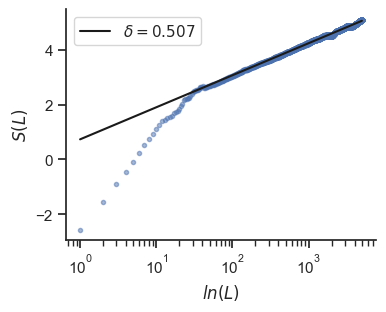

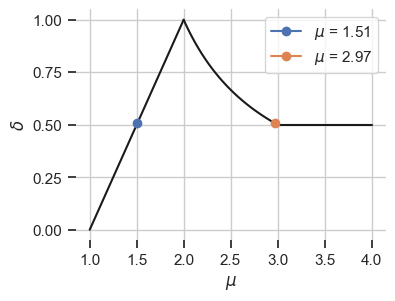

DEA with stripes complete.


In [13]:
import dea
data = dea.make_sample_data(20000, seed=3)  # Example data for demonstration
# data = dea.get_data("/example/path/to/data-file.csv")  # Load data from a file
number_of_stripes = 60
fit_start = 0
fit_stop = int(0.3 * len(data))

dea_result = dea.run_dea_with_stripes(
    data,
    number_of_stripes,
    fit_start,
    fit_stop,
    fit_method="siegel",
    show_data_plot=False
)

## User guide
---

### Procedure 
 
 1. Load your data into the `data` variable. For testing, the `sample_data` function can be used to generate a random walk.
 2. Choose the number of stripes to apply, and the interval (slice) over which to fit.  
 3. Run!  
 4. Adjust `number_of_stripes` and slicing indexes, `fit_start` and `fit_stop`, and re-run, as necessary.  

### Output  

A progress bar will display progress and time elapsed/remaining. On completion, two figures will be drawn with the results:

   - One will be of $S(l)$ vs. $ln(l)$, with the slope fit overlaid. This is the main result.
   - The other will be a display of the two possible values for $\mu$, drawn on a graph of the analytical behavior of $\delta$ vs. $\mu$. This is to help you determine which $\mu$ value is right.

Interpretation of results has its own section, below.  

### Choosing number of stripes  

Run a few initial tests with different values. e.g. 10, 50, 100. If there is significant disagreement in the scalings measured, vary about those trial numbers. The correct number of stripes to use is that number such that when varied up or down a little, the scaling does not change.

Rigorous rules for this are still being developed.

### Choosing fit interval  
In the result figure, if the results are good, there will be a region in the loglog figure that appears linear. You want the fit interval to line up with this region. $S(l)$ is logged in calculation, $l$ is logged by the scale of the plot. The fitting function accounts for this.

## Interpreting Results
---

### Basics  

$\delta$ is the measured scaling of the time-series process.  

$\mu$ is a complexity index, defined as the power for the inter-event time distribution $1/\tau^{\mu}$ ($\tau$ being inter-event time).  

### Baselines  

For a totally random process, DEA yields $\delta = 0.5.$  

The closer $\delta$ is to 1, and the closer $\mu$ is to 2, the more complex the data-series is. Those are the critical values of $\delta$ and $\mu$.  

If $\delta < 0.5$, this usually means the time-series is not complex. At least, not in this sense. 

### Determining $\mu$  
Two ways of calculating $\mu$ are employed:  

 - For $1 < \mu < 2$: $\mu = 1 + \delta$.  
 - For $2 < \mu < 3$: $\mu = 1 + 1/\delta$.  

The correct calculation for $\mu$ varies. As rigorous rules for determining which is correct in what situation have yet to be laid down, both candidates are calculated and plotted so that the user may compare them. Typically the correct value for $\mu$ will lie along the line, as the line represents the theoretical relationship. If you already have an expectation for what range $\mu$ should be in, e.g. from theoretical arguments, use that. The theoretical justifications for the two methods of deriving $\mu$ from the scaling $\delta$ are given in Section 3.2 of Reference 1 and Section 3.1-3.2 of Reference 3.

## References
---

Culbreth, G., West, B.J. and Grigolini, P., 2019. Entropic approach to the detection of crucial events. _Entropy, 21_(2), p.178. doi:[10.3390/e21020178](https://doi.org/10.3390/e21020178)  
 - This paper introduced the stripes and describes their role with figure examples.
 - Note: this paper used $\eta$ to denote scaling, rather than $\delta$.
 
Scafetta, N. and Grigolini, P., 2002. Scaling detection in time series: Diffusion entropy analysis. _Physical Review E, 66_(3), p.036130. doi:[10.1103/PhysRevE.66.036130](https://doi.org/10.1103/PhysRevE.66.036130)  
 - The actual algorithm for DEA is detailed (mostly only in words) in Section IV.  
 
Grigolini, P., Palatella, L. and Raffaelli, G., 2001. Asymmetric anomalous diffusion: an efficient way to detect memory in time series. _Fractals, 9_(04), pp.439-449. doi:[10.1142/S0218348X01000865](https://doi.org/10.1142/S0218348X01000865)  
 - This paper introduced always using positive steps when constructing the event array, rather than the sign of the step at that time index.